In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


1. Getting the DataSet (MNIST for now only to test implementation)

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,)) # Normalize pixel values to range [-1, 1]
])

# I don't know what these do, just copied from documentation...
train_dataset = torchvision.datasets.MNIST(root="../data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="../data", train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 10.3MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 1.97MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 8.30MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.17MB/s]


In [3]:
class CNN(nn.Module):
    # Building the CNN, this is very easy even if it seems complex. You just say the intial size and the desired output size.
    # For CNNs, the size is kind of the amount of "stacked images" that the layer has (I do not fully understand it)
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # Make the image a vector so it can be fed to a normal NN
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4) # I used L2 regularization for this

2. Define a Convolutional Neural Network

My idea for the moment:
- First convolutional layer with 64 filters of 3x3 kernels. (ReLU)
- Reduce image with 2x2 pooling.
- Second convolutional layer with 64 filters of 3x3 kernels. (ReLU)
- Reduce image with 2x2 pooling.
- Flatten output, making it a vector.
- Use this vector to feed a neural network.
- Have two ReLU layers with 128 neurons.
- Output with a 10 neurons softmax layer.

Loss: CrossEntropyLoss

Optimizer: Adam

3. Training the model

In [4]:
num_epochs = 5
loss_hist = []

for epoch in range(num_epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for batch_idx, (images, labels) in pbar:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            pbar.set_postfix(loss=loss.item())
            
            loss_hist.append(loss.item())

Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████████| 235/235 [00:40<00:00,  5.76it/s, loss=0.0134]


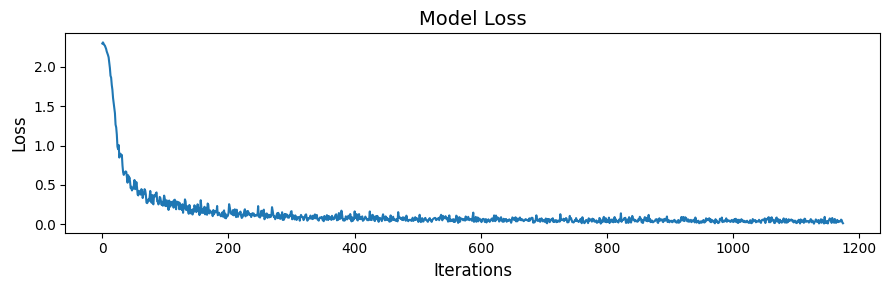

In [5]:
fig, ax = plt.subplots(figsize=(9, 3))

ax.plot(range(len(loss_hist)), loss_hist, label="Loss")
ax.set_xlabel("Iterations", fontsize=12)
ax.set_ylabel("Loss", fontsize=12)
ax.set_title("Model Loss", fontsize=14)
fig.tight_layout()

plt.show()

4. Test model

In [6]:
correct = 0
total = 0

with torch.no_grad(): # Environment without gradient calculation
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.67%
